In [7]:
#stealing code from here: https://www.kaggle.com/xiaozhouwang/2nd-place-lightgbm-solution
# second place kfold lstm^^^^

# as of time of writing may 25, this takes 5 minutes to gen features. still slow :/
import numpy as np
import pandas as pd
import os, time, gc, pickle, random
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
from pytorch_pretrained_bert import BertTokenizer, BertModel
from bert_embedding import BertEmbedding
import apex # used for 16 bit
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import mxnet as mx # used for GPU
#for getting num good and bad words
from wordcloud import STOPWORDS
from collections import defaultdict
import operator
import swifter # speed up feature gen - multiple cores
%set_env PYTHONBREAKPOINT=IPython.core.debugger.set_trace
from sklearn.model_selection import train_test_split


from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

# Logging for BERT
import logging
logging.basicConfig(level=logging.INFO)


from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


env: PYTHONBREAKPOINT=IPython.core.debugger.set_trace


/home/curtis/miniconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
# helper functions
string.printable
ascii_chars = string.printable
ascii_chars += " áéíóúàèìòùâêîôûäëïöüñõç"

#checks if a string of text contains any nonenglish characters (excluding punctuations, spanish, and french characters)
def contains_non_english(text):
    if all(char in ascii_chars for char in text):
        return 0
    else:
        return 1
    
#clean non english characters from string of text
def remove_non_english(text):
    return ''.join(filter(lambda x: x in ascii_chars, text))


def get_first_word(word):
    if(type(word) != "float"):
        return word.split(" ")[0]
    return "-1"

def get_caps_vs_length(df):
    df['caps_vs_length'] = df['num_caps'].divide(df['num_chars'])
    df.loc[~np.isfinite(df['caps_vs_length']), 'caps_vs_length'] = 0
    
"""    mask = (df['num_chars'] != 0)
    df_valid = df[mask]
    
    df.loc[mask, 'caps_vs_length'] = df_valid['num_caps'] / df_valid['num_chars']"""

def get_unique_word_over_num_words(df):
    df['unique_word_over_num_words'] = df['num_unique_words'].divide(df['num_words'])
    df.loc[~np.isfinite(df['unique_word_over_num_words']), 'unique_word_over_num_words'] = 0
    
def get_avg_word_len(df):
    df['avg_word_len'] = df['total_word_length'].divide(df['num_words'])
    df.loc[~np.isfinite(df['avg_word_len']), 'avg_word_len'] = 0

def get_avg_unique_word_len(df):
    df['avg_unique_word_len'] = df['total_unique_word_length'].divide(df['num_unique_words'])
    df.loc[~np.isfinite(df['avg_unique_word_len']), 'avg_unique_word_len'] = 0
    
def calc_max_word_len(sentence):
    maxLen = 0
    for word in sentence:
        maxLen = max(maxLen, len(word))
    return maxLen

def calc_min_word_len(sentence):
    minLen = 999999
    for word in sentence:
        minLen = min(minLen, len(word))
    return minLen

def calc_total_word_len(sentence):
    cnt = 0
    for x in sentence:
        cnt+=len(x)
    return cnt

def calc_total_unique_word_len(sentence):
    words = set(sentence)
    return calc_total_word_len(words)

#removes all single characters except for "I" and "a"
def remove_singles(text):
    return ' '.join( [w for w in text.split() if ((len(w)>1) or (w.lower() == "i") or (w.lower() == "a"))] )
    
#combines multiple whitespaces into single
def clean_text(x):
    x = str(x)
    for punct in "&/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&':
        x = x.replace(punct, '')
    x = re.sub( '\s+', ' ', x).strip()
    
    
# Text cleaning
# TODO: speed up this func
def pad_chars(text,punct):
    for p in punct:
        text = re.sub('(?<=\w)([!?,])', r' \1', text)
    return text
    
symbols_iv = """?,./-()"$=…*&+′[ɾ̃]%:^\xa0\\{}–“”;!<`®ạ°#²|~√_α→>—£，。´×@π÷？ʿ€の↑∞ʻ℅в•−а年！∈∩⊆§℃θ±≤͡⁴™си≠∂³ி½△¿¼∆≥⇒¬∨∫▾Ω＾γµº♭ー̂ɔ∑εντσ日Γ∪φβ¹∘¨″⅓ɑː✅✓（）∠«»்ுλ∧∀،＝ɨʋδɒ¸☹μΔʃɸηΣ₅₆◦·ВΦ☺❤♨✌≡ʌʊா≈⁰‛：ﬁ„¾ρ⟨⟩˂⅔≅－＞¢⁸ʒは⬇♀؟¡⋅ɪ₁₂ɤ◌ʱ、▒ْ；☉＄∴✏ωɹ̅।ـ☝♏̉̄♡₄∼́̀⁶⁵¦¶ƒˆ‰©¥∅・ﾟ⊥ª†ℕ│ɡ∝♣／☁✔❓∗➡ℝ位⎛⎝¯⎞⎠↓ɐ∇⋯˚⁻ˈ₃⊂˜̸̵̶̷̴̡̲̳̱̪̗̣̖̎̿͂̓̑̐̌̾̊̕\x92"""        

def split_off_symbols_iv(x):
    for punct in symbols_iv:
        x = x.replace(punct, f' {punct} ')
    return x
    
def neutrailize_bad_words(train,test):
    train1_df = train[train["target"]==1]
    train0_df = train[train["target"]==0]

    ## custom function for ngram generation ##
    def generate_ngrams(text, n_gram=1):
        token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
        ngrams = zip(*[token[i:] for i in range(n_gram)])
        return [" ".join(ngram) for ngram in ngrams]

    freq_dict_bad = defaultdict(int)
    for sent in train1_df["comment_text"]:
        for word in generate_ngrams(sent):
            freq_dict_bad[word] += 1
    freq_dict_bad = dict(freq_dict_bad)

    freq_dict_good = defaultdict(int)
    for sent in train0_df["comment_text"]:
        for word in generate_ngrams(sent):
            freq_dict_good[word] += 1
    freq_dict_good = dict(freq_dict_good)

    bad_words = sorted(freq_dict_bad, key=freq_dict_bad.get, reverse=True)[:1000]
    good_words = sorted(freq_dict_good, key=freq_dict_good.get, reverse=True)[:1000]

    print("--- Generating num_bad_words")
    train["num_bad_words"] = train["comment_text"].map(lambda x: num_bad_words(x))
    test["num_bad_words"] = test["comment_text"].map(lambda x: num_bad_words(x))

    print("--- Generating num_good_words")
    train["num_good_words"] = train["comment_text"].map(lambda x: num_good_words(x))
    test["num_good_words"] = test["comment_text"].map(lambda x: num_good_words(x))

    return x

In [6]:
def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    
    # Feature generation
    
    def gen_feats(df):
        start_time = time.time()
            
        print("--- Generating non_eng")
        df["non_eng"] = df["comment_text"].swifter.apply(lambda x: contains_non_english(x))
        print("--- Finished Gen Feats. Took %s seconds ---" % (time.time() - start_time))

        print("--- Generating first_word")
        df["first_word"] = df["comment_text"].swifter.apply(lambda x: get_first_word(x))

        print("--- Generating num_chars (num chars)")
        df['num_chars'] = df['comment_text'].swifter.apply(len)

        print("--- Generating num_caps")
        df['num_caps'] = df['comment_text'].swifter.apply(lambda comment: sum(1 for c in comment if c.isupper()))

        print("--- Generating caps_vs_length")
        get_caps_vs_length(df)

        print("--- Generating num_exclamation_marks")
        df['num_exclamation_marks'] = df['comment_text'].apply(lambda comment: comment.count('!'))

        print("--- Generating num_question_marks")
        df['num_question_marks'] = df['comment_text'].apply(lambda comment: comment.count('?'))

        print("--- Generating num_punctuation")
        df['num_punctuation'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))

        print("--- Generating num_symbols")
        df['num_symbols'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))

        print("--- Generating num_words")
        df['num_words'] = df['comment_text'].swifter.apply(lambda comment: len(re.sub(r'[^\w\s]','',comment).split(" ")))

        print("--- Generating num_unique_words")
        df['num_unique_words'] = df['comment_text'].swifter.apply(lambda comment: len(set(w for w in comment.split())))

        print("--- Generating unique_word_over_num_words")
        get_unique_word_over_num_words(df)

        print("--- Generating num_smilies")
        df['num_smilies'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))

        print("--- Generating num_sentences")
        df['num_sentences'] = df['comment_text'].swifter.apply(lambda comment: len(re.split(r'[.!?]+', comment)))

        print("--- Generating max_word_len")
        df['max_word_len'] = df['comment_text'].swifter.apply(lambda comment: calc_max_word_len(re.sub(r'[^\w\s]','',comment).split(" ")))
        
        print("--- Generating min_word_len")
        df['max_word_len'] = df['comment_text'].swifter.apply(lambda comment: calc_min_word_len(re.sub(r'[^\w\s]','',comment).split(" ")))
        
        print("--- Generating total_word_length (num of chars in words)")
        df['total_word_length'] = df['comment_text'].swifter.apply(lambda comment: calc_total_word_len(re.sub(r'[^\w\s]','',comment).split(" ")))
        
        print("--- Generating avg_word_len")
        get_avg_word_len(df)
        
        print("--- Generating total_unique_word_length (num of chars in words)")
        df['total_unique_word_length'] = df['comment_text'].swifter.apply(lambda comment: calc_total_unique_word_len(re.sub(r'[^\w\s]','',comment).split(" ")))
        
        print("--- Generating avg_unique_word_len")
        get_avg_unique_word_len(df)
        
        print("--- Finished Gen Feats. Took %s seconds ---" % (time.time() - start_time))
        

    def cleanText(df):
        start_time = time.time()
        df['comment_text'] = df['comment_text'].swifter.apply(lambda x: split_off_symbols_iv(x)) #increase score
        """print("--- cleaning text")
        df["comment_text"] = df["comment_text"].apply(lambda x: clean_text(x))

        print("--- remove single characters")
        df["comment_text"] = df["comment_text"].apply(lambda x: remove_singles(x))

        print("--- cleaning numbers")
        df["comment_text"] = df["comment_text"].apply(lambda x: clean_numbers(x))

        print("--- cleaning misspellings")
        df["comment_text"] = df["comment_text"].apply(lambda x: replace_typical_misspell(x))

        print("--- filling missing values")
        #clean chinese, korean, japanese characters
        print('cleaning characters')
        df["comment_text"] = df["comment_text"].map(lambda x: remove_non_english(x))
        
        ## fill up the missing values
        df["comment_text"].fillna("").values"""
        print("--- Finished cleaning text. Took %s seconds ---" % (time.time() - start_time))

        
    gen_feats(data)
    #data["comment_text"] = data["comment_text"].astype(str).apply(lambda x: pad_chars(x, punct))
    #cleanText(data)
    # print("--- Neutralizing bad words")
    # neutrailize_bad_words(train,test)
    
    return data

In [7]:
DATA_SIZE = ""
print("--- Loading Files")
start_time = time.time()
train = pd.read_hdf('../input/train.h5')
test = pd.read_hdf('../input/test.h5')
print("--- Finished Loading %s" % (time.time() - start_time))

if DATA_SIZE == "small":
    print("Using small data")
    train = train[:100]
    test = test[:100]
elif DATA_SIZE == "med":
    print("Using med data")
    train = train[:10000]
    test = test[:10000]

print("--- Preprocess")
start_time = time.time()
#preprocess(train)
#preprocess(test)
print("--- Finished preprocess %s" % (time.time() - start_time))

--- Loading Files
--- Finished Loading 2.3633694648742676
--- Preprocess
--- Finished preprocess 3.266334533691406e-05


In [8]:
train

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.000000,...,2006,rejected,0,0,0,1,0,0.000000,4,47
5,59859,0.666667,ur a sh*tty comment.,0.047619,0.638095,0.000000,0.333333,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.009524,0,105
6,59861,0.457627,hahahahahahahahhha suck it.,0.050847,0.305085,0.000000,0.254237,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.220339,0,59
7,59863,0.000000,FFFFUUUUUUUUUUUUUUU,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.000000,0,4
8,239575,0.000000,The ranchers seem motivated by mostly by greed...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,26662,approved,0,0,0,0,0,0.000000,0,4
9,239576,0.000000,It was a great show. Not a combo I'd of expect...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,26650,approved,0,0,0,1,0,0.000000,0,4


In [6]:
#train.to_hdf('../input/train_feats_v1.h5',key='train_feats')
#test.to_hdf('../input/test_feats_v1.h5',key='test_feats')

In [8]:
SMALL_DATA = False
train = pd.read_hdf('../input/train_feats_v1.h5')
test = pd.read_hdf('../input/test_feats_v1.h5')
if SMALL_DATA:
    train = train[:100]
    test = test[:100]

In [9]:
split_perc = 0.9

train_len = len(train)
split_point = int(split_perc*train_len)

#first_word omitted
features = ['non_eng','num_chars','num_caps','caps_vs_length','num_exclamation_marks','num_question_marks','num_punctuation','num_symbols','num_words','num_unique_words','unique_word_over_num_words','num_smilies','num_sentences','max_word_len','max_word_len','total_word_length','avg_word_len','total_unique_word_length','avg_unique_word_len']
#x_train = train[:split_point][features]
#x_test = test[split_point:][features]

#y_train = train[:split_point]['target']
#y_aux_train = [[] for x in range(len(x_train))]

x_train = train[features]
y_train = train['target']
#y_train = np.where(train['target'] >= 0.5, 1, 0)

x_test = test[features]

In [10]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances01.png')

In [11]:
NUM_SPLITS = 5
bins = np.linspace(0, 1, 100) 
y_binned = np.digitize(y_train, bins)
    
random_state = 42
skf = StratifiedKFold(n_splits = NUM_SPLITS, shuffle=True, random_state=random_state)
#skf.get_n_splits(x_train)

In [12]:
def custom_loss(data, targets):
    ''' Define custom loss function for weighted BCE on 'target' column '''
    bce_loss_1 = nn.BCEWithLogitsLoss(weight=targets[:,1:2])(data[:,:1],targets[:,:1])
    bce_loss_2 = nn.BCEWithLogitsLoss()(data[:,1:],targets[:,2:])
    return (bce_loss_1 * loss_weight) + bce_loss_2

In [13]:
def to_categorical(preds):
    return np.where(preds >= 0.5,1,0)

In [14]:
def loglikelihood(preds, train_data):
    labels = train_data.get_label()
    preds = 1. / (1. + np.exp(-preds))
    grad = preds - labels
    hess = preds * (1. - preds)
    return grad, hess

Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 0.0377264	training's auc: 0.589283	valid_1's l2: 0.0379381	valid_1's auc: 0.583953
Early stopping, best iteration is:
[1709]	training's l2: 0.0375809	training's auc: 0.59397	valid_1's l2: 0.0379235	valid_1's auc: 0.584139
Fold  1 AUC : 0.500216
Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 0.0377228	training's auc: 0.589899	valid_1's l2: 0.0379513	valid_1's auc: 0.581162
Early stopping, best iteration is:
[1680]	training's l2: 0.0375818	training's auc: 0.594671	valid_1's l2: 0.037938	valid_1's auc: 0.581395
Fold  2 AUC : 0.500151
Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 0.0377185	training's auc: 0.589789	valid_1's l2: 0.037985	valid_1's auc: 0.580244
[2000]	training's l2: 0.0375487	training's auc: 0.595125	valid_1's l2: 0.0379705	valid_1's auc: 0.580487
Early stopping, best iteration is:
[1814]	training's l2: 0.0375533	t

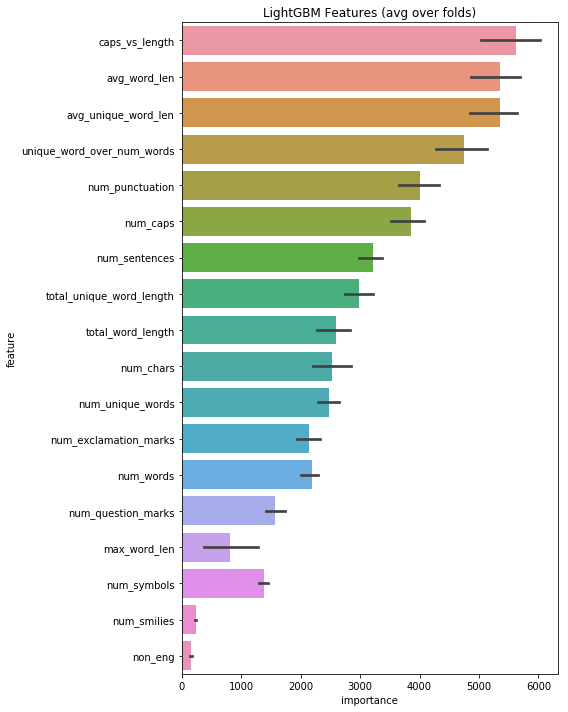

In [15]:
#note: stratified ensures that each fold is representative of the datasett
# so it needs the distributions of the target variable
debug = True
oof_preds = np.zeros(train.shape[0])
sub_preds = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()
for fold, (trn_idxs, val_idxs) in enumerate(skf.split(train[features],y_binned)):
    train_x, train_y = train[features].iloc[trn_idxs], train['target'].iloc[trn_idxs]
    valid_x, valid_y = train[features].iloc[val_idxs], train['target'].iloc[val_idxs]

    # LightGBM parameters found by Bayesian optimization
    clf = LGBMRegressor(
        nthread=4,
        #is_unbalance=True,
        n_estimators=10000,
        learning_rate=0.02,
        num_leaves=32,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.04,
        reg_lambda=0.073,
        min_split_gain=0.0222415,
        min_child_weight=40,
        silent=-1,
        verbose=-1,
        #scale_pos_weight=11
        )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)

    oof_preds[val_idxs] = clf.predict(valid_x, num_iteration=clf.best_iteration_)
    sub_preds += clf.predict(test[features], num_iteration=clf.best_iteration_) / NUM_SPLITS

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (fold + 1, roc_auc_score(to_categorical(valid_y), to_categorical(oof_preds[val_idxs]))))
    
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()
print('Full AUC score %.6f' % roc_auc_score(to_categorical(train['target']), to_categorical(oof_preds)))
# Write submission file and plot feature importance
if not debug:
    test['target'] = sub_preds
    test[['id', 'target']].to_csv(submission_file_name, index= False)
display_importances(feature_importance_df)
print(feature_importance_df)

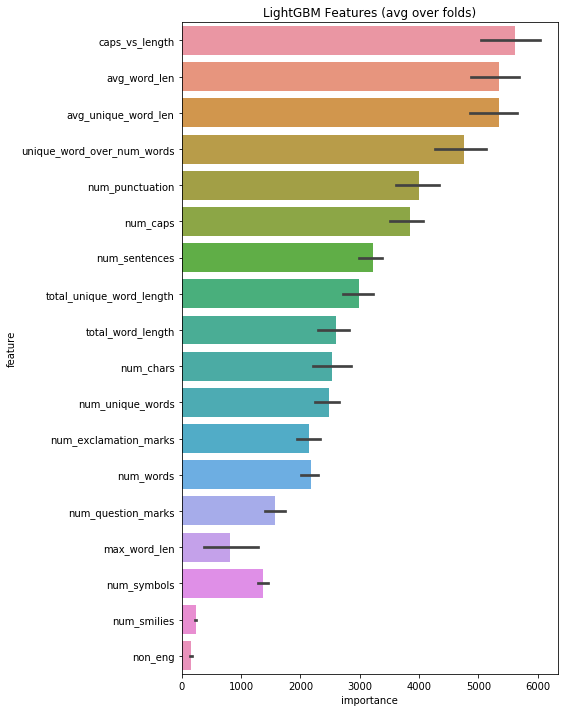

In [16]:
display_importances(feature_importance_df)

In [17]:
print('Full AUC score %.6f' % roc_auc_score(to_categorical(train['target']), to_categorical(oof_preds)))

Full AUC score 0.500160


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d955af2e8>]],
      dtype=object)

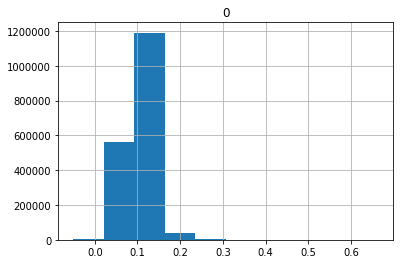

In [24]:
pd.DataFrame(oof_preds).hist()